PyImageJ Tutorial
===

This notebook covers how to use ImageJ as a library from Python. A major advantage of this approach is the ability to combine ImageJ with other tools available from the Python software ecosystem, including NumPy, SciPy, scikit-image, CellProfiler, OpenCV, ITK and more.

This notebook assumes familiarity with the ImageJ API. Detailed tutorials in that regard can be found in the other notebooks.

## 9 Troubleshooting

### 9.1 I can't pass my numpy image to an `Op`

`ij.py` is really good at converting numpy images into `RandomAccessibleInterval`s. However many `Op`s, like `addPoissonNoise`, take other forms of ImageJ images, like `IterableInterval`.

In [32]:
print(ij.op().help('filter.addPoissonNoise'))

Available operations:
	(RealType out) =
	net.imagej.ops.filter.addPoissonNoise.AddPoissonNoiseRealType(
		RealType out,
		RealType in,
		long seed?)
	(IterableInterval out) =
	net.imagej.ops.filter.addPoissonNoise.AddPoissonNoiseMap(
		IterableInterval out,
		IterableInterval in)


We can't call this `Op` on a numpy array since it is a specialized type of `RandomAccessibleInterval`, which does not extend `IterableInterval`.

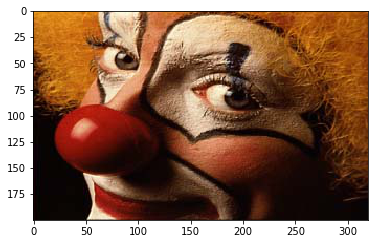

<java class 'net.imglib2.python.ReferenceGuardingRandomAccessibleInterval'>


In [33]:
# Create a numpy image using scikit
img = io.imread('https://imagej.net/images/clown.jpg')

ij.py.show(img)
print(type(ij.py.to_java(img)))

We can fix this by using `transform.flatIterableView` on both the input and output, which will convert the `ReferenceGuardedRandomAccessibleInterval`s into `IterableInterval`s, allowing us to pass our numpy image into `addPoissonNoise`:

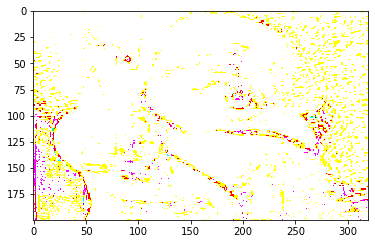

In [34]:
result = np.zeros(img.shape) # HINT: Uses float dtype, for more accurate noising.

imgIterable = ij.op().transform().flatIterableView(ij.py.to_java(img))
resIterable = ij.op().transform().flatIterableView(ij.py.to_java(result))

ij.op().filter().addPoissonNoise(resIterable, imgIterable)

ij.py.show(result)

Uh oh. Something's off with the data values—see next section!

### 9.2 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats of [0..255] for integers

This message is given either because (as described in the warning)

* The data consists of floats that are outside the range of [0..1]. This is pretty common and definitely is the case as to why the above data looks so bad.
* The data consists of ints that are outside the range [0..255].

Let's be certain which is the culprit by checking some values of `result`:

In [35]:
# grab the RGB values in a line from [0][5] to [0][10] in our image
print(result[0][5:10])

[[250. 161.  48.]
 [254. 184.  46.]
 [247. 174.  37.]
 [244. 167.  39.]
 [256. 166.  42.]]


Thus we not only have floats outside of [0..1] but also values outside of [0..255]; we are faulty of both points in the warning. We can fix this by first [clipping](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.clip.html) the entire array within the integer range, then cast to `uint8` so that the float range no longer applies:

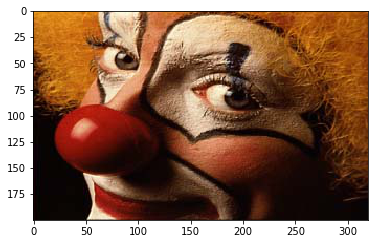

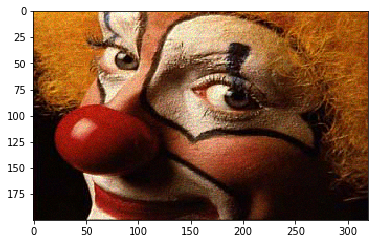

In [36]:
ij.py.show(img.astype(int))
       
result = np.clip(result, 0, 255)
ij.py.show(result.astype(np.uint8))

Now our noisy image displays nicely alongside the original. Note that depending on your data this might not be the right path for you, but using `clip` and `astype` are great tools for rearranging your data within these bounds.